<a href="https://colab.research.google.com/github/ProfAI/tf00/blob/master/11%20-%20Serie%20Storiche/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione del Meteo
In questo video vedremo come utilizzare Tensorflow e le Reti Neurali Ricorrenti per eseguire forecasting di serie storiche. Una serie storica è un'insieme di dati in sequenza temporale e il forecasting è il processo di predizione di dati futuri, cioè di come la sequenza potrebbe continuare. Per il nostro esempio proveremo a cercare di predire la temperatura futura a Jena, una paese della Germania.

## Importiamo i moduli

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, GlobalMaxPooling1D

## Scarichiamo i dati

In [3]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2020-07-10 10:41:40--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 64.233.181.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  58.8MB/s    in 0.2s    

2020-07-10 10:41:40 (58.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


## Definiamo le Costanti

In [4]:
WINDOW_SIZE = 20

## Prepariamo i Dati
Carichiamo il CSV che abbiamo scaricato dentro ad un DataFrame di Pandas.

In [54]:
df = pd.read_csv("jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


LA colonna con la temperatura in gradi centigradi campionata ogni 10 minuti è *T (degC)*, estraiamone i valori in un'array numpy.

In [55]:
temp_data = df["T (degC)"].values

Il metodo che viene solitamente utilizzato per addestrare modelli sulle serie storiche è quello di utilizzare un determinato intervallo temporale come feature e il valore immediatamente successivo all'intervallo come target. Ad esempio, se la nostra serie è composta da questa sequenza di numeri: *1, 2, 3, 4, 5, 6* e come intervallo temporale scegliamo 3, allora il nostro datset sarà così composto:

>Features | Target
>--- | ---
>1, 2, 3 | 4
>2, 3, 4 | 5
>3, 4, 5 | 6

Definiamo una funzione per creare il dataset.


In [56]:
def make_sequence_data(data, window_state, target_future=1):

    X = []
    y = []

    for i in range(0, data.shape[0]-window_state*target_future):
      X.append(np.reshape(data[i:i+window_state], (window_state, 1)))
      y.append(data[i+window_state*target_future])

    return np.array(X), np.array(y)


X, y = make_sequence_data(temp_data, WINDOW_SIZE)
print(X.shape)
print(y.shape)

(420531, 20, 1)
(420531,)


Tramite il parametro *traget_future* possiamo controllare la distanza dalle features del target, nel caso volessimo addestrare un modello in grado di eseguire predizioni più distanti nel futuro, ad esempio, se la nostra sequenza è questa: 1, 2, 3, 4, 5, 6 ,7 ,8 ,9 ,10, utilizziamo un'intervallo temporale di 4 e un target future di 3, allora il dataset sarà così composto:

>Features | Target
>--- | ---
>1, 2, 3, 4 | 7
>2, 3, 4, 5 | 8
>3, 4, 5, 6 | 9
>4, 5, 6, 7 | 10

A differenza di altri tipi di dati, quando lavoriamo con le serie storiche dobbiamo dividere il dataset in train set e test set senza mescolarlo, definiamo una funzione per farlo.

In [57]:
def train_test_split_series(X, y, test_size=0.25):

  samples_count = X.shape[0]
  sets_delimiter = samples_count-int((1-test_size)*samples_count)

  X_train = X[:sets_delimiter,:,:]
  X_test = X[sets_delimiter:,:,:]

  y_train = y[:sets_delimiter]
  y_test = y[sets_delimiter:]

  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split_series(X, y)
print(X_train.shape)
print(X_test.shape)

(105133, 20, 1)
(315398, 20, 1)


Ora eseguiamo la standardizzazione, ricordiamoci che media e deviazione standard qui calcolati ci serviranno anche per standardizzare nuovi dati che vorremo passare alla rete addestrata.

In [58]:
mean_value = X_train.mean()
std_value = X_train.std()

X_train = (X_train-mean_value)/std_value
X_test = (X_test-mean_value)/std_value

## Predirre il Meteo 10 minuti nel futuro
Creiamo una prima Rete LSTM per predire il meteo un minuto nel futuro, in questo caso si tratta di un problema di regressione, dato che il target è una variabile continua, quindi possiamo non specificare una funzione di attivazione per lo strato di output.

In [59]:
model = Sequential()
model.add(LSTM(8, input_shape=[WINDOW_SIZE,1]))
model.add(Dense(1))

Addestriamo il modello per 5 epoche, utilizzando *Mean Absolute Error* come funzione di costo.

In [60]:
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
3286/3286 [==============================] - 18s 6ms/step - loss: 2.3870
Epoch 2/5
3286/3286 [==============================] - 18s 5ms/step - loss: 0.3212
Epoch 3/5
3286/3286 [==============================] - 18s 5ms/step - loss: 0.1927
Epoch 4/5
3286/3286 [==============================] - 18s 5ms/step - loss: 0.1590
Epoch 5/5
3286/3286 [==============================] - 18s 5ms/step - loss: 0.1447


Il risultato sul train set e molto buono, vediamo sul test set.

In [61]:
model.evaluate(X_test, y_test)

9857/9857 [==============================] - 31s 3ms/step - loss: 0.1366


0.13662436604499817

Anche qui il risultato è buono, definiamo una funzione per stampare su di un unico grafico sia la serie reale che quella predetta dal modello.

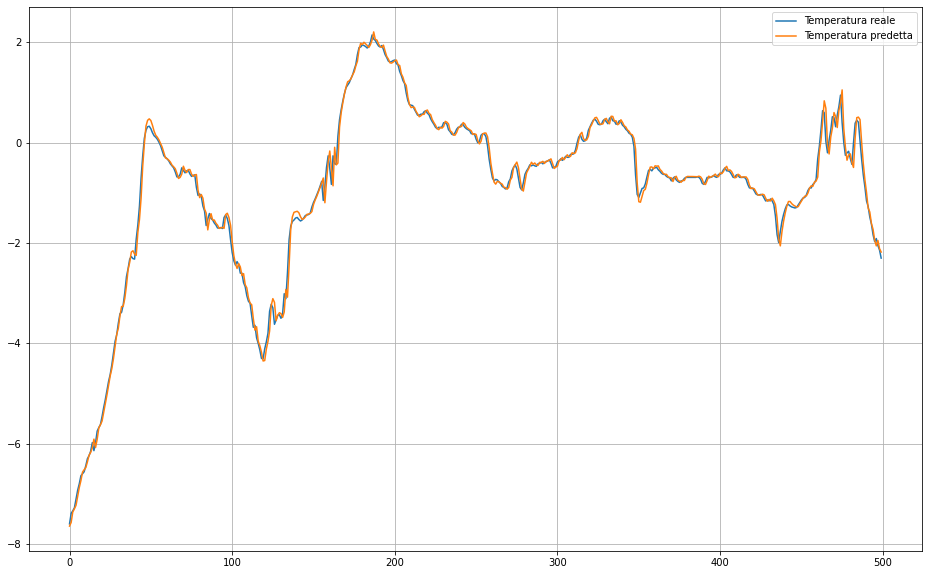

In [62]:
def plot_series_prediction(y_true, y_pred, figsize=(16,10)):
  plt.figure(figsize=figsize)
  plt.grid()
  plt.plot(y_true, label="Temperatura reale")
  plt.plot(y_pred, label="Temperatura predetta")
  plt.legend()

y_pred = model.predict(X_test)
plot_series_prediction(y_test[:500], y_pred[:500])

Le predizioni del modello sono molto buone, ma al momento sta predicendo la temperatura nei 10 minuti successivi, proviamo a spingerci oltre.

## Predirre il Meteo 1 Ora nel Futuro

Proviamo ad addestrare una Rete LSTM questa volta per predire la temperatura nell'ora successiva, creiamo il dataset utilizzando la stessa funzione che abbiamo definito prima, ma questa volta impostiamo *target_future* a 6.

In [63]:
X, y = make_sequence_data(temp_data, 20, target_future=6)
X_train, X_test, y_train, y_test = train_test_split_series(X, y)

Definiamo il modello ed eseguiamo l'addestramento

In [64]:
model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences=True, input_shape=[WINDOW_SIZE,1])))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
3285/3285 [==============================] - 64s 19ms/step - loss: 3.6534
Epoch 2/20
3285/3285 [==============================] - 64s 19ms/step - loss: 3.4353
Epoch 3/20
3285/3285 [==============================] - 64s 20ms/step - loss: 3.3579
Epoch 4/20
3285/3285 [==============================] - 64s 20ms/step - loss: 3.3024
Epoch 5/20
3285/3285 [==============================] - 65s 20ms/step - loss: 3.2556
Epoch 6/20
3285/3285 [==============================] - 64s 20ms/step - loss: 3.2094
Epoch 7/20
3285/3285 [==============================] - 65s 20ms/step - loss: 3.1761
Epoch 8/20
3285/3285 [==============================] - 65s 20ms/step - loss: 3.1590
Epoch 9/20
3285/3285 [==============================] - 64s 20ms/step - loss: 3.1271
Epoch 10/20
3285/3285 [==============================] - 64s 20ms/step - loss: 3.1176
Epoch 11/20
3285/3285 [==============================] - 64s 20ms/step - loss: 3.0958
Epoch 12/20
3285/3285 [==============================] - 65s 20

In [50]:
model.evaluate(X_test, y_test)

9857/9857 [==============================] - 71s 7ms/step - loss: 0.3991


0.3990629017353058

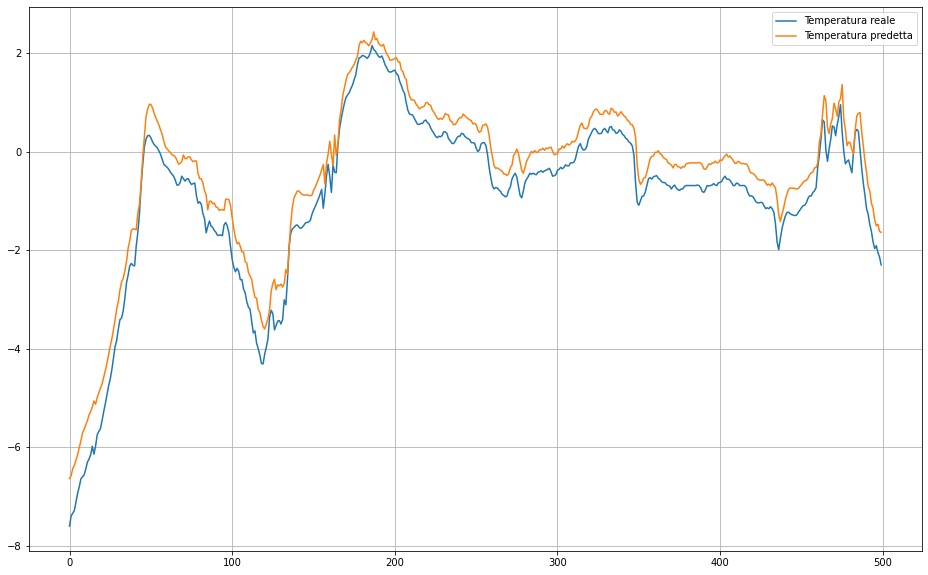

In [ ]:
y_pred = model.predict(X_test)
plot_series_prediction(y_test[:500], y_pred[:500])

Ovviamente più andiamo nel futuro con le predizioni, più bassa sarà l'accuratezza del nostro modello.

## Forecasting
Vediamo ora come utilizzare un modello addestrato per predire come la sequenza potrebbe continuare. Addestriamo nuovamente il modello per eseguire predizioni 10 minuti nel futuro, questa volta utilizzando il modello più complesso che abbiamo definito appena sopra.

In [45]:
X, y = get_xy(temp_data, 20)
X_train, X_test, y_train, y_test = train_test_split_series(X, y)

model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences=True, input_shape=[WINDOW_SIZE,1], )))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
#model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=20)

model.evaluate(X_test, y_test)

Epoch 1/20
2446/3286 [=====================>........] - ETA: 16s - loss: 1.5517

KeyboardInterrupt: ignored

Ora definiamo una funzione per eseguire il forecasting, la quale funzionerà così:
1. Definiamo quanto lunga dovrà essere la sequenza predetta, cioè quanti valori nel futuro vogliamo predire.
2. Passiamo al modello l'ultima osservazione del Test Set, chiamiamola x
3. Utilizziamo il modello per predire il valore successivo nella sequenza, chiamiamolo y_next
4. Aggiungiamo y_next ad una lista di valori predetti.
5. Standardizziamo y_next.
6. Rimuoviamo il primo elemento di x e aggiungiamo y_next come ultimo elemento.
7. Ripetiamo dal punto 1 fino ad aver ottenuto il numero di previsioni che abbiamo definito.

In [43]:
def forecasting(model, x_start, times):

  forecast = []

  for _ in range(times):

    pred = model.predict(x_start.reshape(1, WINDOW_SIZE, 1))[0]
    forecast.append(pred)

    pred_std = (pred-mean_value)/std_value
    x_start = np.append(x_start[1:], pred_std)

  return np.array(forecast)


forecast = forecasting(model, X_test[-1,:,:], 30)

Definiamo ora una funzione per stampare il grafico di come la serie potrebbe continuare nel futuro.

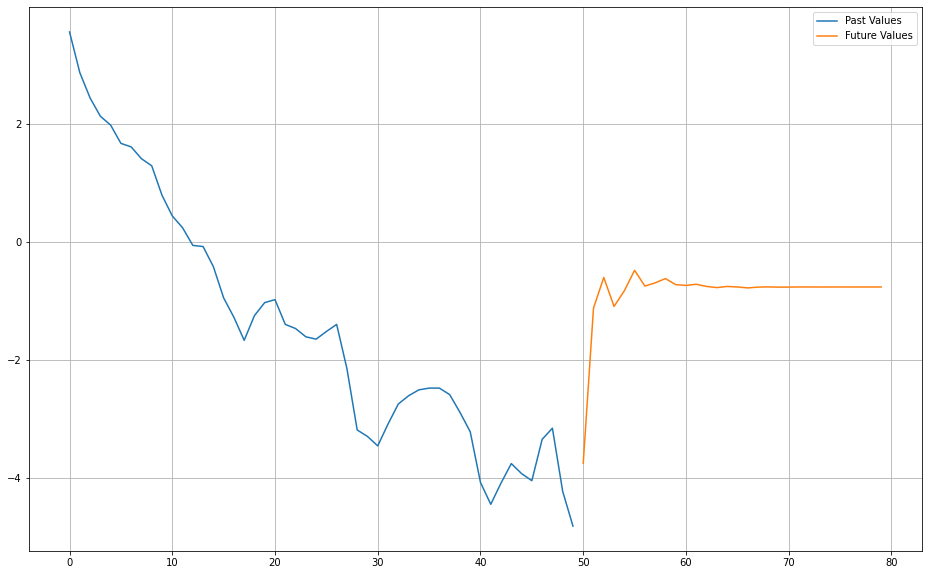

In [44]:
def plot_forecast(y_past, y_forecast, figsize=(16, 10)):

  plt.figure(figsize=figsize)
  plt.grid()

  past_count = y_past.shape[0]
  forecast_count = y_forecast.shape[0]

  plt.plot(np.arange(past_count), y_past, label="Past Values")
  plt.plot(np.arange(past_count, past_count+forecast_count), forecast, label="Future Values")
  plt.legend()


plot_forecast(y_test[-50:], forecast)